In [1]:
!pip3 install torchinfo
!pip3 install pytorchcv
!pip3 install torchsummary
!pip3 install torchvision

In [253]:
#기본 임포트
import builtins
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv
from torchsummary import summary
from torch import optim
from torch.utils.data import Subset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import TensorDataset
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
#디바이스 설정
default_device = 'cuda' if torch.cuda.is_available() else 'cpu'
#default_device = 'cpu'

In [4]:
#데이터 불러오는 함수
raw_train_data = torchvision.datasets.FashionMNIST('./data', download = True, train = True, transform = ToTensor()) # train data 다운로드
raw_test_data = torchvision.datasets.FashionMNIST('./data', download = True, train = False, transform = ToTensor()) # test data 다운로드

In [61]:
# train image data 
train_data = raw_train_data.train_data

# train label data
train_label = raw_train_data.train_labels

# valid와 test로 나누기
# data 문제, label이 정답
valid_img, test_img, valid_label, test_label = train_test_split(raw_test_data.test_data, raw_test_data.test_labels, train_size = 0.5, random_state = 1)

# 결과 확인용 데이터
result_test_img = test_img[0]
result_test_label = test_label[0]

#input 타입 정리
train_data = train_data.reshape(train_data.shape[0], 1, 28, 28).float()/255
valid_img = valid_img.reshape(valid_img.shape[0], 1, 28, 28).float()/255
test_img = test_img.reshape(test_img.shape[0], 1, 28, 28).float()/255

# train 데이터 개수 확인
print("train 데이터 개수 :", train_data.shape)

# valid 데이터 개수 확인
print("valid 데이터 개수 :", valid_img.shape)

# test 데이터 개수 확인
print("test 데이터 개수 :", test_img.shape)

train 데이터 개수 : torch.Size([60000, 1, 28, 28])
valid 데이터 개수 : torch.Size([5000, 1, 28, 28])
test 데이터 개수 : torch.Size([5000, 1, 28, 28])


/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
# 분류 확인
print("이미지 분류")
print(raw_train_data.classes)

print()

# 각 분류별 인덱스 확인
print("이미지 분류 별 인덱스")
print(raw_train_data.class_to_idx)

이미지 분류
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

이미지 분류 별 인덱스
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


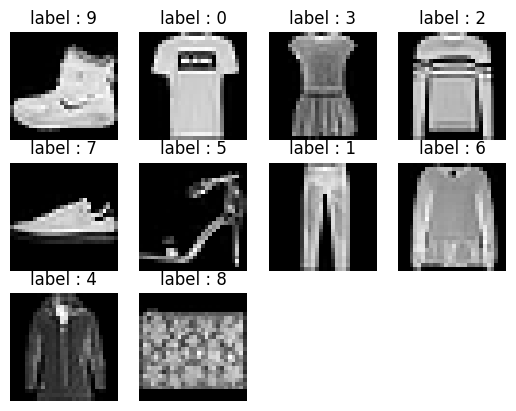

In [7]:
# 각 라벨별 이미지 확인
list = []
for i in range(50):
    one_image, label = raw_train_data[i]
    
    if list == [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        break
        
    if label in list:
        continue

    else:
        list.append(label)
        list.sort()
        plt.subplot(3, 4, len(list))
        plt.axis("off")
        plt.imshow(one_image.squeeze().numpy(), cmap='gray')
        title = "label : " + str(label)
        plt.title(title)

plt.show()

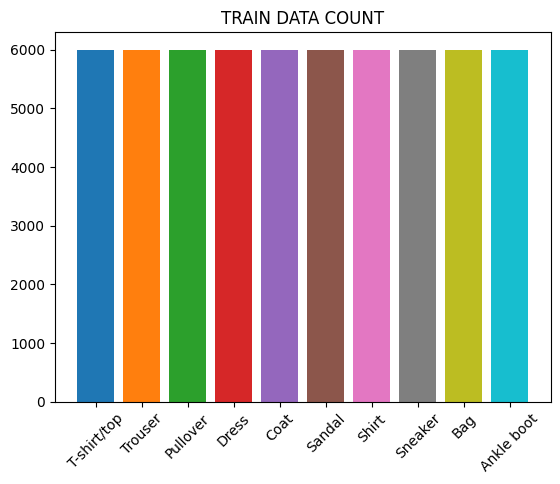

In [8]:
# 각 종류별 데이터 개수 확인
data_count = [0 for i in range(10)]

for i in range(len(raw_train_data)):
    img, label = raw_train_data[i]
    data_count[label] += 1

category = {v:k for k,v in raw_train_data.class_to_idx.items()}

plt.title("TRAIN DATA COUNT")
for i in range(10):
    plt.bar(category.get(i), data_count[i])
    plt.xticks(rotation = 45)

plt.show()

In [9]:
#모델 만들기
class cnnmodel(nn.Module):
    #사진 한 장을 처리
    def __init__(self):
        super(cnnmodel, self).__init__()

        # conv2d는 컨볼루션 레이어 생성 함수
        # 기본 사진은 3색 RGB로 있어서 3개의 층이 쌓여있는 것. 그러나 흑백은 1개의 층 밖에 없음
        # in_channels이 1이라는 것은 흑백사진이 입력으로 들어간다는 것을 의미 (3일 경우, 컬러 사진)
        # out_channels이 9라는 것은 1개의 층을 특성별로 나눠 9개의 층으로 바꾼다는 것을 의미 그리고, depth를 의미함
        # 스트라이드가 없으므로 기본 값 1 이는 한 칸씩 움직이는 것을 의미
        # conv를 하면 (24 x 24 x 9)의 결과가 나옴. 
        # 24는 28(이미지 크기) - 5(커널 사이즈) + 1(스트라이드)이고 9는 out_channels
        self.conv = nn.Conv2d(in_channels = 1, out_channels = 9, kernel_size = (5, 5))
        
        # MaxPool2d는 풀링 레이어 생성 함수
        # 풀링 레이어는 사이즈를 줄이는 것 
        # MaxPooling은 가장 큰 수를 유지하면서 사이즈를 줄이는 방식
        # kernel_size을 2로 적용
        # pool을 하면 (12 x 12 x 9)가 나옴
        self.pool = nn.MaxPool2d(kernel_size = 2)
        
        # 3차원 행렬을 1차원 행렬로 변환하는 과정
        # flatten을 하면 1296이 나옴
        self.flatten = nn.Flatten()

        # 전결합층 레이어(fc)에 넣는 과정
        # Linear(입력 레이어 개수, 출력 레이어 개수)
        # 1296인 12 * 12 * 9인 flatten의 결과 값
        self.fc = nn.Linear(1296, 10)

    #순전파 부분
    def forward(self, x):
        if x.dim() == 5 and x.size(2) == 1:
            x = x.squeeze(2)

        #conv 레이어 적용
        x = self.conv(x)
        
        #relu 적용
        x = nn.functional.relu(x)
        
        #plooling 레이어 적용
        x = self.pool(x)

        #flatten 적용
        x = self.flatten(x)

        #확률 계산하는 softmax 적용
        x = nn.functional.log_softmax(self.fc(x), dim = 1)
        return x 

#모델 생성 및 저장
#모델과 데이터를 같은 곳에 올려야 함
model = cnnmodel().to(default_device)

#모델 요약
summary(model, input_size = (1, 1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
         MaxPool2d-2            [-1, 9, 12, 12]               0
           Flatten-3                 [-1, 1296]               0
            Linear-4                   [-1, 10]          12,970
Total params: 13,204
Trainable params: 13,204
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.05
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [10]:
#분할한 데이터 묶어주기
valid_data = TensorDataset(valid_img, valid_label)
test_data = TensorDataset(test_img, test_label)

# train, valid, test 각각 배치 사이즈 128로 로드
train_loader = torch.utils.data.DataLoader(dataset = raw_train_data, batch_size = 128, shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset = valid_data, batch_size = 128, shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 128, shuffle = False)

In [11]:
# 옵티마이저 선언 (Adam 사용)
# lr은 학습률의 의미
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# 손실함수 선언 (크로스 엔트로피 손실 함수 사용)
criterion = torch.nn.CrossEntropyLoss().to(default_device)

In [12]:
#학습 진행

#10번 학습을 진행 
epochs = 10

history = {"train_loss":[], "train_acc":[], "valid_loss":[], "valid_acc":[]}

for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for data, target in train_loader:
        data, target = data.to(default_device), target.to(default_device)
        
        #역전파시 간섭을 막기 위해 zero 초기화
        optimizer.zero_grad()

        #모델 학습 결과
        predict = model(data).to(default_device)

        #모델 학습 결과가 없을 경우
        if predict is None:
            print("모델 실행 결과가 없습니다.")
            continue

        #손실 계산
        loss = criterion(predict, target) 
        
        #손실 계산 값이 없을 경우
        if loss is None:
            print("손실 계산 결과가 없습니다.")
            continue

        #역전파
        loss.backward()

        #단일 optimization step을 수행하고 파라미터 업데이트
        optimizer.step()

        #손실과 정확도 중간 저장
        train_loss += loss.item()
        _, predicted = torch.max(predict.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * train_correct / train_total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    #모델 평가 진행
    model.eval()
    valid_loss, valid_correct, valid_total = 0, 0, 0
    
    with torch.no_grad():
        #for data, target in valid_loader:
        for data, target in valid_loader:
            data, target = data.to(default_device), target.to(default_device)

            #평가 결과 
            output = model(data).to(default_device)

            #평가 결과가 없을 경우
            if output is None:
                print("모델 평가에 대한 실행 결과가 없습니다.")
                continue

            #손실 계산
            loss = criterion(output, target)

            #손실 계산 값이 없을 경우
            if loss is None:
                print("모델 평가에 대한 손실 계산 결과가 없습니다.")
                continue

            #손실과 정확도 저장
            valid_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            valid_total += target.size(0)
            valid_correct += (predicted == target).sum().item()
    
    valid_loss /= len(valid_loader.dataset)
    valid_acc = 100. * valid_correct / valid_total
    history['valid_loss'].append(valid_loss)
    history['valid_acc'].append(valid_acc)
    
    print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')

Epoch 1/10: Train Loss: 0.0048, Train Acc: 79.55%, Test Loss: 0.0038, Test Acc: 83.02%
Epoch 2/10: Train Loss: 0.0031, Train Acc: 86.04%, Test Loss: 0.0033, Test Acc: 85.36%
Epoch 3/10: Train Loss: 0.0028, Train Acc: 87.31%, Test Loss: 0.0029, Test Acc: 87.08%
Epoch 4/10: Train Loss: 0.0027, Train Acc: 88.04%, Test Loss: 0.0029, Test Acc: 86.98%
Epoch 5/10: Train Loss: 0.0025, Train Acc: 88.62%, Test Loss: 0.0026, Test Acc: 88.26%
Epoch 6/10: Train Loss: 0.0025, Train Acc: 88.89%, Test Loss: 0.0026, Test Acc: 88.22%
Epoch 7/10: Train Loss: 0.0024, Train Acc: 89.40%, Test Loss: 0.0026, Test Acc: 88.10%
Epoch 8/10: Train Loss: 0.0023, Train Acc: 89.52%, Test Loss: 0.0025, Test Acc: 88.72%
Epoch 9/10: Train Loss: 0.0023, Train Acc: 89.81%, Test Loss: 0.0025, Test Acc: 88.64%
Epoch 10/10: Train Loss: 0.0022, Train Acc: 89.97%, Test Loss: 0.0025, Test Acc: 88.82%


{'train_loss': [0.004774811187883218,
  0.0031397028488417467,
  0.0028407963427404563,
  0.002661174986511469,
  0.0025397472627460955,
  0.002462475172430277,
  0.0023679713644087315,
  0.002321344426025947,
  0.002265091115484635,
  0.0022240754589438437],
 'train_acc': [79.55,
  86.03666666666666,
  87.31166666666667,
  88.04333333333334,
  88.62166666666667,
  88.89,
  89.40333333333334,
  89.52333333333333,
  89.805,
  89.96833333333333],
 'valid_loss': [0.003781935232877731,
  0.003274773347377777,
  0.002936389708518982,
  0.0029044585764408113,
  0.0026388291597366333,
  0.002627741485834122,
  0.002616335475444794,
  0.0024976656883955004,
  0.0025228788137435913,
  0.00247261164188385],
 'valid_acc': [83.02,
  85.36,
  87.08,
  86.98,
  88.26,
  88.22,
  88.1,
  88.72,
  88.64,
  88.82]}

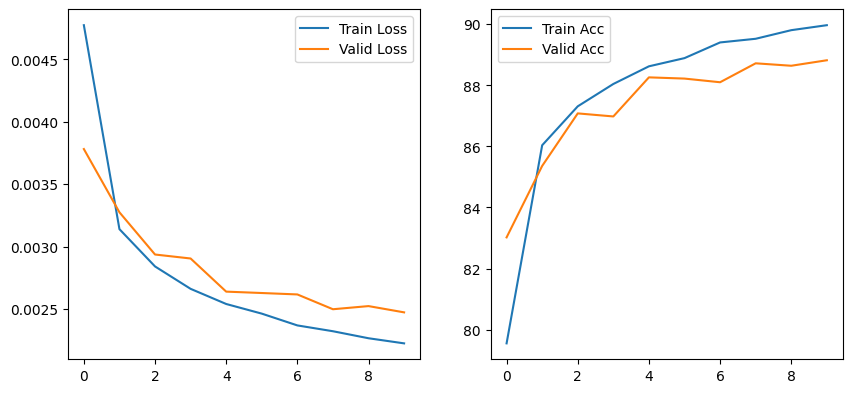

In [41]:
#차트 가로 세로 길이
plt.figure(figsize = (10, 10))

#Loss 그래프 그리기
plt.subplot(221)
plt.plot(history.get('train_loss'), label = "Train Loss")
plt.plot(history.get('valid_loss'), label = "Valid Loss")
plt.legend()

#Acc 그래프 그리기
plt.subplot(222)
plt.plot(history.get('train_acc'), label = "Train Acc")
plt.plot(history.get('valid_acc'), label = "Valid Acc")
plt.legend()

plt.show()

In [48]:
#test 데이터로 최종 평가
model.eval()
X_test, y_test = test_img.to(default_device), test_label.to(default_device)
result = model(X_test)

#Loss 값 계산
loss = criterion(result, y_test)

#정확도 계산
_, pred = torch.max(result.data, 1)
accuracy = 100.*(pred == y_test).sum().item() / len(pred)

#결과 출력
print(f"Test loss : {loss.item():.9f}")
print(f"Test accuracy : {accuracy:5.2f} %")

Test loss : 0.326873600
Test accuracy : 88.86 %


테스트 결과
예측 : Pullover
정답 : Shirt


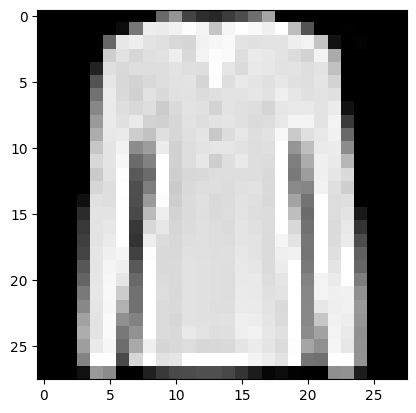

In [218]:
#예측 결과 보기
print("테스트 결과")

plt.imshow(result_test_img.squeeze().numpy(), cmap='gray')

pred_index = int(str(pred[0]).split("(")[1].split(")")[0])
label_index = int(str(y_test[0]).split("(")[1].split(")")[0])

print("예측 : " + category.get(pred_index))
print("정답 : " + category.get(label_index))


In [222]:
correct, wrong = 0, 0

for i in range(len(pred)):
    pred_index = int(str(pred[0]).split("(")[1].split(")")[0])

    if pred[i] == y_test[i]:
        correct += 1
    else:
        wrong += 1

print("테스트 데이터의 수 : " + str(correct + wrong))
print("맞게 예측한 데이터의 수 : " + str(correct))
print("잘못 예측한 데이터의 수 : " + str(wrong))


테스트 데이터의 수 : 5000
맞게 예측한 데이터의 수 : 4443
잘못 예측한 데이터의 수 : 557


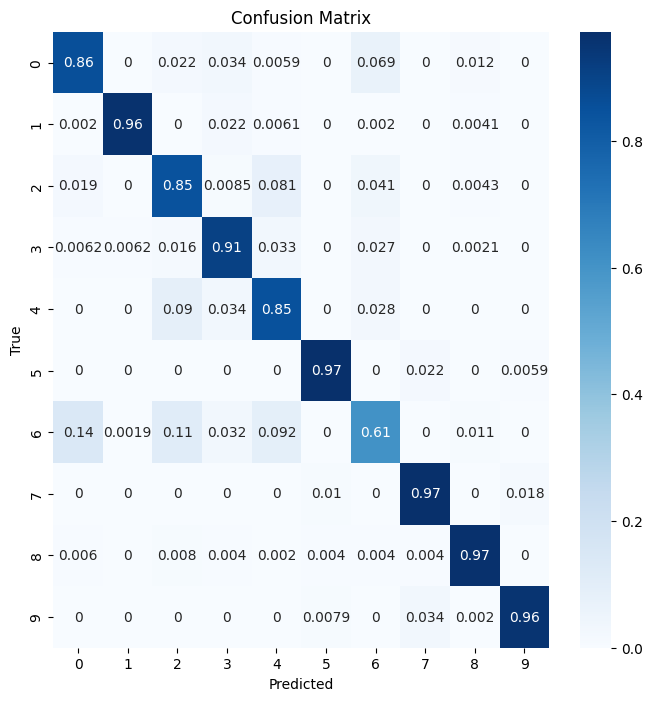

In [279]:
#confusion_matrix로 결과 확인
cm = confusion_matrix(test_label, pred, labels = None, sample_weight = None, normalize = 'true')

plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [189]:
#어떤 것으로 잘못 예측했는지 확인
wrong_result = [[0 for j in range(10)] for i in range(10)]

#전체 결과
test_result = {"correct" : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] , "wrong" : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "wrong_value" : wrong_result}

correct, wrong = 0, 0

for i in range(len(pred)):
    for j in range(10):
        pred_index = int(str(pred[i]).split("(")[1].split(")")[0])
        label_index = int(str(y_test[i]).split("(")[1].split(")")[0])

        if pred[i] == y_test[i]:
            test_result['correct'][pred_index] += 1 #맞게 예측했을 때 정답-correct에 +1

        else:
            test_result['wrong'][label_index] += 1 #잘못 예측했을 때 정답 - wrong에 +1
            test_result['wrong_value'][label_index][pred_index] += 1 #정답으로 예측한 라벨 카운트 +1

test_result

{'correct': [4330, 4750, 3960, 4430, 4240, 4930, 3220, 4870, 4870, 4830],
 'wrong': [720, 180, 720, 440, 760, 140, 2090, 140, 160, 220],
 'wrong_value': [[0, 0, 110, 170, 30, 0, 350, 0, 60, 0],
  [10, 0, 0, 110, 30, 0, 10, 0, 20, 0],
  [90, 0, 0, 40, 380, 0, 190, 0, 20, 0],
  [30, 30, 80, 0, 160, 0, 130, 0, 10, 0],
  [0, 0, 450, 170, 0, 0, 140, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 110, 0, 30],
  [760, 10, 600, 170, 490, 0, 0, 0, 60, 0],
  [0, 0, 0, 0, 0, 50, 0, 0, 0, 90],
  [30, 0, 40, 20, 10, 20, 20, 20, 0, 0],
  [0, 0, 0, 0, 0, 40, 0, 170, 10, 0]]}

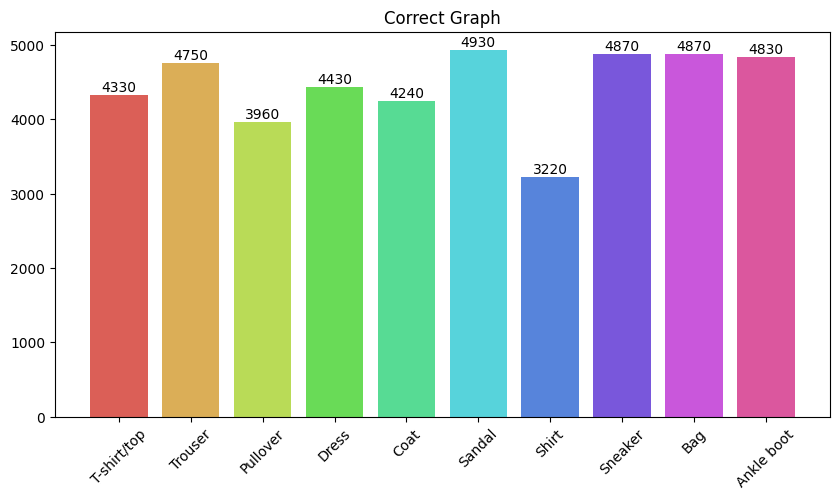

In [241]:
#정답 리스트
correct_list = test_result['correct']

#색상 지정 
colors = sns.color_palette('hls',len(correct_list))

#차트 크기
plt.figure(figsize = (10, 5))

#차트 이름
plt.title('Correct Graph')

#차트 그리기
bar = plt.bar(category.values(), correct_list, color = colors)

#x 라벨 45도 돌리기
plt.xticks(rotation = 45)

for i, j in enumerate(bar) :
    plt.text(i, j.get_height() + 50, correct_list[i], ha = 'center')
    
#그래프 출력
plt.show()

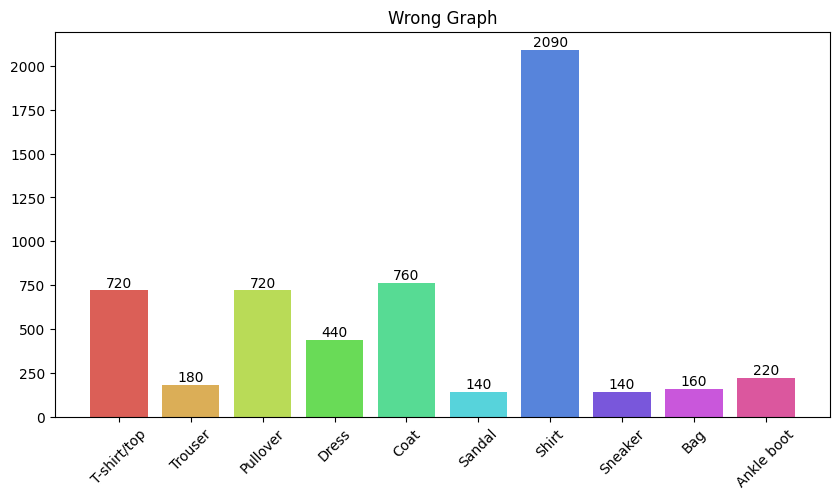

In [246]:
#오답 리스트
wrong_list = test_result['wrong']

#색상 지정 
colors = sns.color_palette('hls',len(correct_list))

#차트 크기
plt.figure(figsize = (10, 5))

#차트 이름
plt.title('Wrong Graph')

#차트 그리기
bar = plt.bar(category.values(), wrong_list, color = colors)

#x 라벨 45도 돌리기
plt.xticks(rotation = 45)

for i, j in enumerate(bar) :
    plt.text(i, j.get_height() + 20, wrong_list[i], ha = 'center')
    
#그래프 출력
plt.show()

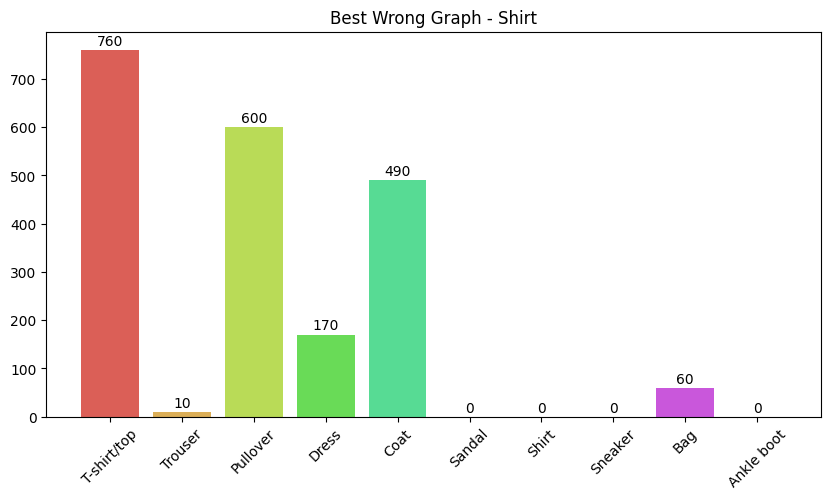

In [252]:
#가장 인식을 잘못한 Shirt에 대한 통계 값
best_wrong = test_result['wrong_value'][6]

#색상 지정 
colors = sns.color_palette('hls',len(correct_list))

#차트 크기
plt.figure(figsize = (10, 5))

#차트 이름
plt.title('Best Wrong Graph - Shirt')

#차트 그리기
bar = plt.bar(category.values(), best_wrong, color = colors)

#x 라벨 45도 돌리기
plt.xticks(rotation = 45)

for i, j in enumerate(bar) :
    plt.text(i, j.get_height() + 10, best_wrong[i], ha = 'center')
    
#그래프 출력
plt.show()

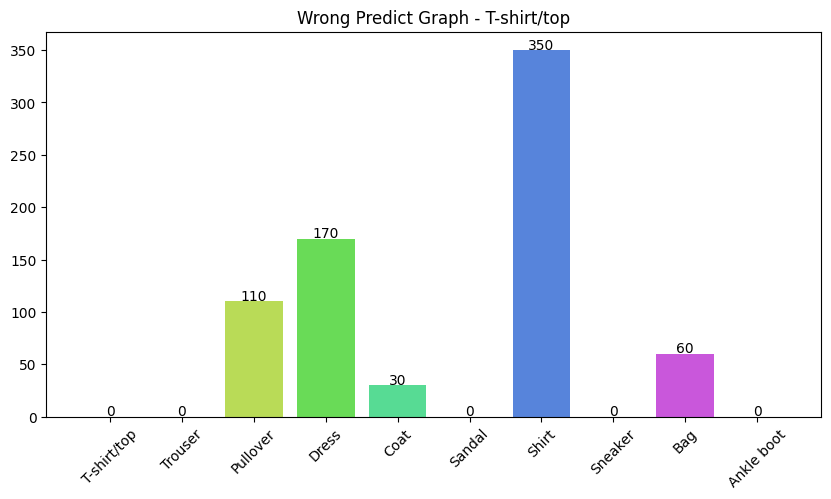

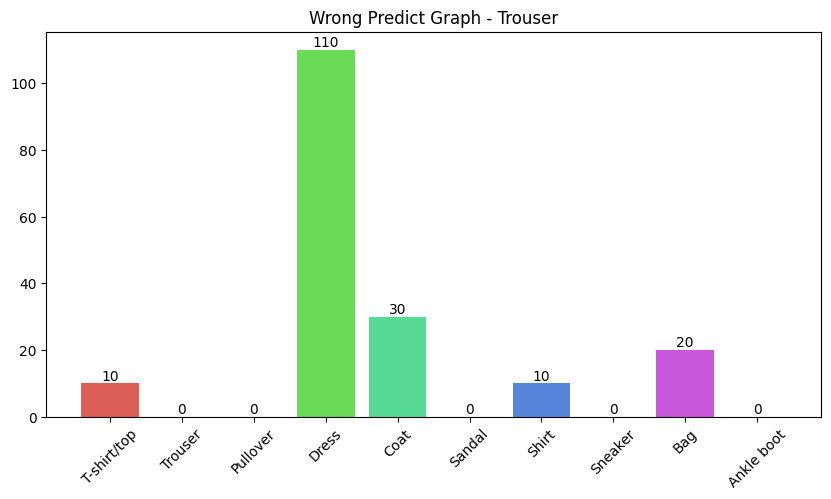

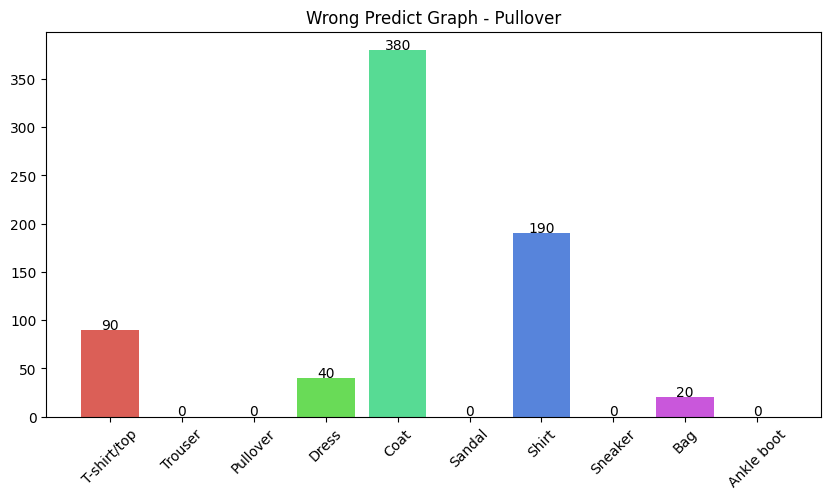

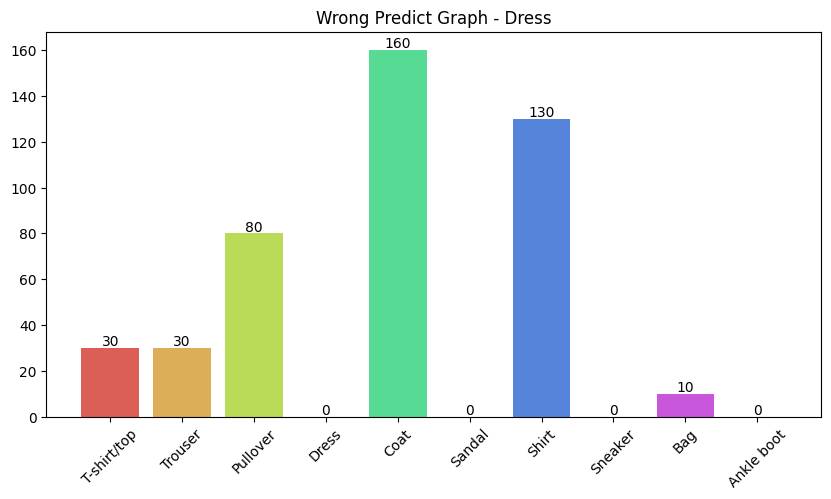

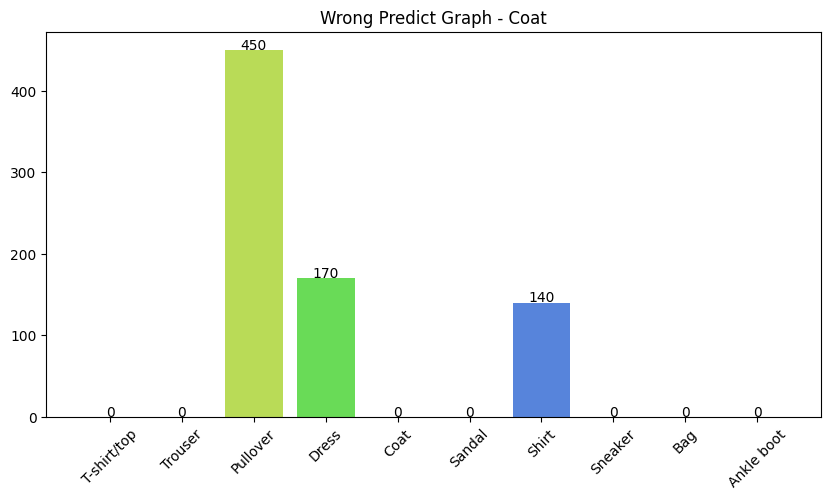

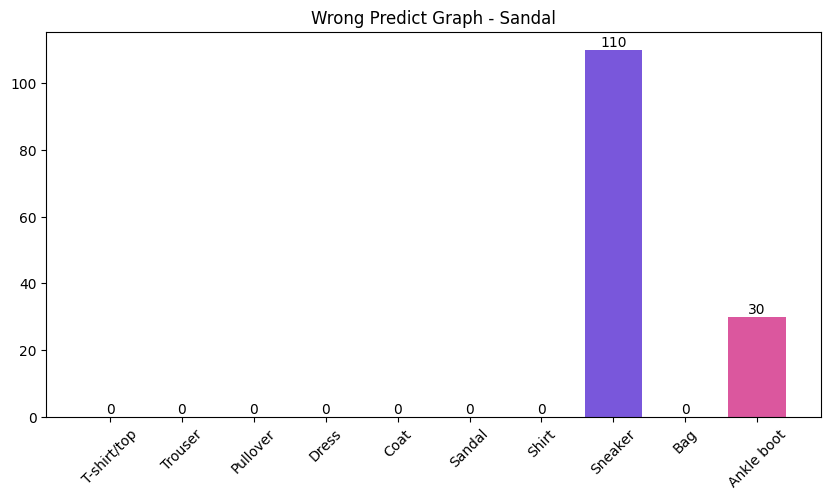

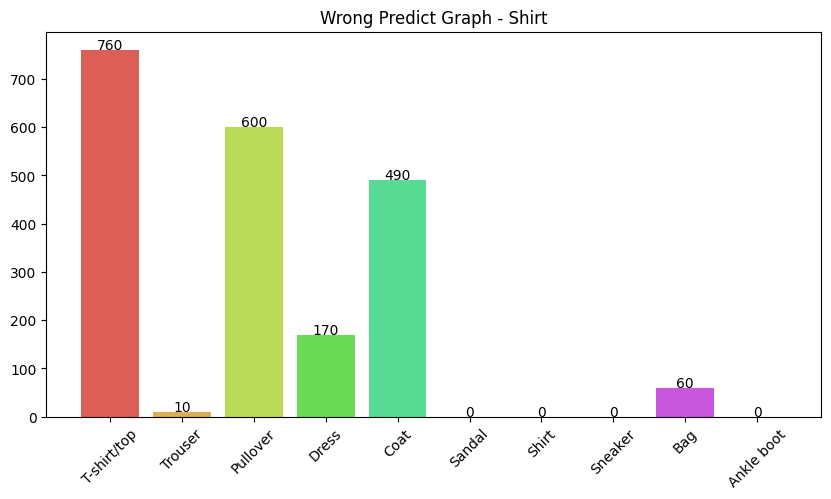

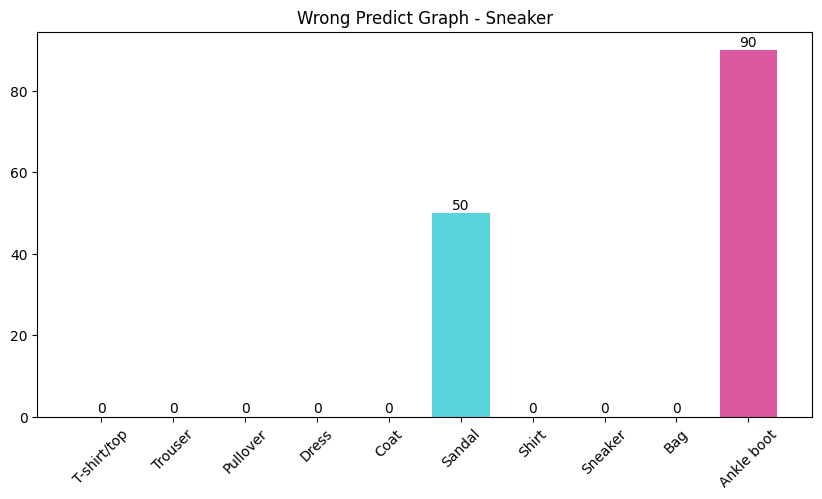

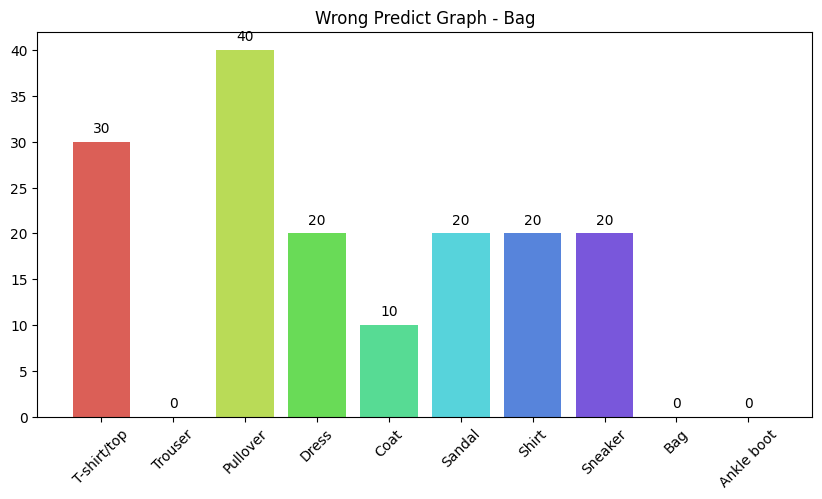

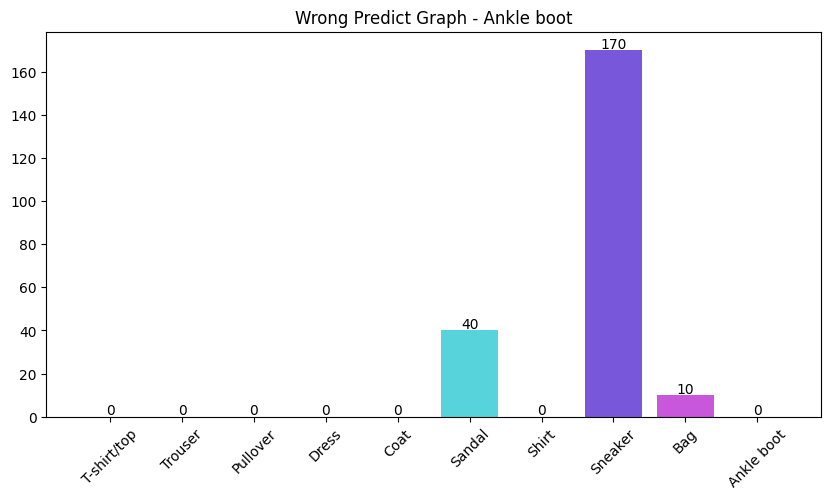

In [290]:
#색상 지정 
colors = sns.color_palette('hls',len(correct_list))

for i in range(10):

    #차트 크기
    plt.figure(figsize = (10, 5))

    #차트 이름
    plt.title('Wrong Predict Graph - ' + category[i])

    #차트 그릴 리스트
    plt_list = test_result['wrong_value'][i]

    #차트 그리기
    bar = plt.bar(category.values(), plt_list, color = colors)

    #x 라벨 45도 돌리기
    plt.xticks(rotation = 45)

    for i, j in enumerate(bar) :
        plt.text(i, j.get_height() + 1, plt_list[i], ha = 'center')
    
    plt.show()
